In [3]:
!export CUDA_VISIBLE_DEVICES=0

import torch, os
import numpy as np 

import matplotlib.pyplot as plt

from copy import deepcopy
from plotly.offline import init_notebook_mode

from vae_dist.dataset.dataset import FieldDataset
from vae_dist.data.visualize import get_latent_space
from vae_dist.core.training_utils import construct_model 
from vae_dist.dataset.fields import split_and_filter
import json 

init_notebook_mode(connected=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# plot isosurface of a given scalar field 


In [3]:
model_list = []
model_names = "model_single_datapoint.ckpt"

for model_type in ['auto']:
    options = json.load(open('./options/options_{}_default.json'.format(model_type)))
    model_temp = construct_model(model_type, options)
    model_temp.load_model("./log_version_{}_1/{}".format(model_type, model_names))
    model_temp.to(device)
    model_list.append(deepcopy(model_temp))

inner_dim:  10
channel_in:  1
channel_out:  32
kernel:  4
stride:  1
channel_in:  32
channel_out:  64
kernel:  3
stride:  1
channel_in:  64
channel_out:  128
kernel:  3
stride:  1
channel_in:  128
channel_out:  256
kernel:  3
stride:  1
channel_in:  256
channel_out:  512
kernel:  3
stride:  1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 18, 18, 18]           2,080
              ReLU-2       [-1, 32, 18, 18, 18]               0
         ConvBatch-3       [-1, 32, 18, 18, 18]               0
            Conv3d-4       [-1, 64, 16, 16, 16]          55,360
              ReLU-5       [-1, 64, 16, 16, 16]               0
         ConvBatch-6       [-1, 64, 16, 16, 16]               0
            Conv3d-7      [-1, 128, 14, 14, 14]         221,312
              ReLU-8      [-1, 128, 14, 14, 14]               0
         ConvBatch-9      [-1, 128, 14, 14, 14]               0
 

In [4]:
root = '../../data/single_field/'

dataset_single = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    lower_filter=True,
    log_scale=True, 
    scalar=True,
    device=device
    )

dataset_loader_full = torch.utils.data.DataLoader(
                dataset_single, 
                batch_size=1,
                shuffle=True,
                num_workers=0
            )

Largest value in dataset:  5.230252635633907
Smallest value in dataset:  0.0
Nan values in dataset:  False
Inf values in dataset:  False


Aug
Total number of fields:  5
Aug


IndexError: list index out of range

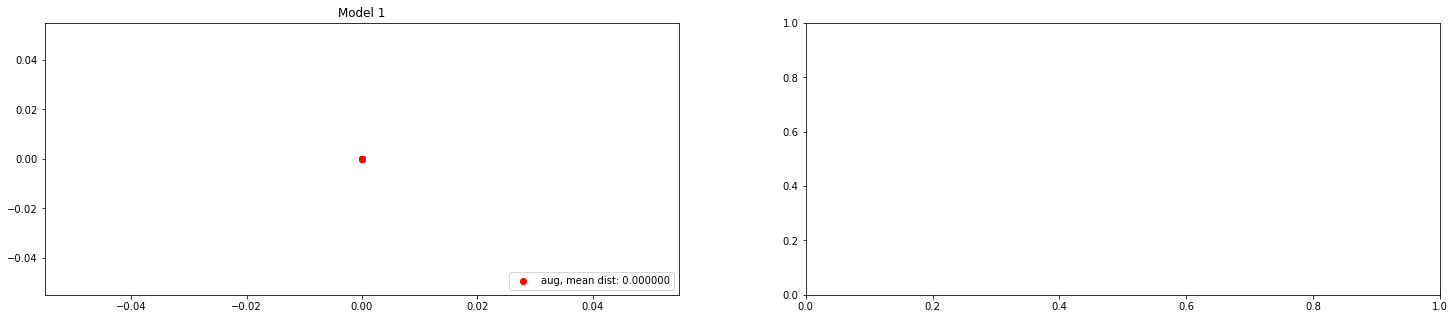

In [5]:
def mean_distance(latent_space):
    mean_dist = 0
    for i in range(latent_space.shape[0]):
        for j in range(latent_space.shape[0]):
            mean_dist += np.linalg.norm(latent_space[i] - latent_space[j])
    mean_dist /= latent_space.shape[0]**2
    return mean_dist


def get_latent_space(model, dataset, comp=[0, 2], latent_dim=10):
    latent_space = []
    # convert load to numpy 
    dataset_loader_np = []
    print("Total number of fields: ", len(dataset))
    for ind in range(len(dataset)):
        field=dataset[ind].reshape(1, 1, 21, 21, 21)
        latent = model.latent(field)
        #print(latent.shape)
        latent_space.append(latent.detach().cpu().numpy())
    if comp == []:
        return np.array(latent_space).reshape(-1, latent_dim)
    else: 
        return np.array(latent_space).reshape(-1, latent_dim)[:, comp]
    

fig, axs = plt.subplots(1, 2, figsize=(25, 5))
# iterate over the sub plots
for i, ax in enumerate(axs.flatten()):
    # plot the data
    print("Aug")
    latent_space_aug = get_latent_space(model_list[i], dataset_single, comp=[0, 1], latent_dim=100)
    mean_aug = mean_distance(latent_space_aug)

    ax.scatter(
        latent_space_aug[:, 0], 
        latent_space_aug[:, 1], c="red", 
        label="aug, mean dist: {:.6f}".format(mean_aug))

    # legend bottom right
    ax.legend(loc="lower right")
    ax.set_title(f"Model {i+1}")

In [20]:
import plotly.graph_objects as go
import numpy as np

def plot_sfield(scalar_field, z_level=0.0):
    # plot iso surface of a given scalar field
    # z_level: iso surface level
    # sweep x, y and get z as value of scalar field at z level
    x = np.linspace(0, 1, 21)
    y = np.linspace(0, 1, 21)
    z = scalar_field[:, : , 11]

    iso =go.Surface(x=x, y=y, z=z)
    return iso


def show_in_out_plots(in_field, model):
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'surface'}, {'type': 'surface'}]])

    model = model_list[0]
    x = in_field.reshape(1, 1, 21, 21, 21).to(device)
    x_out = model.forward(x)
    x_out = x_out.to('cpu').detach().numpy().reshape(1, 21, 21, 21)

    field_in =  plot_sfield(x.cpu().numpy())
    field_out = plot_sfield(x_out)
    #plot surface in subplots
    # add traces
    fig.add_trace(field_in, 1, 1, showcolorbar=False, showscale= False)
    fig.add_trace(field_out, 1, 2, showcolorbar=False, showscale= False)
    fig.show()
    
show_in_out_plots(dataset_single[0], model_list[0])
#plot_sfield(dataset_single[0], model_list[0])


In [25]:
dataset_single[0]

tensor([[[[0.8515, 0.7099, 0.5679,  ..., 0.0000, 0.0000, 0.0000],
          [0.5467, 0.3621, 0.5411,  ..., 0.0000, 0.0000, 0.0000],
          [0.6301, 0.6643, 0.5832,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.6063, 1.7710, 1.1360,  ..., 0.0000, 0.0000, 0.0000],
          [0.5028, 0.3099, 0.4982,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[2.1409, 0.9314, 1.9961,  ..., 0.0000, 0.0000, 0.0000],
          [0.4982, 0.3044, 0.4941,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.3809, 1.9610, 1.6127,  ..., 0.0000, 0.0000, 0.0000],
          [0.2852, 0.1484, 0.4762,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.9891, 1.5936, 1.0851,  ..., 0.0000, 0.0000, 0.0000],
          [0.2852, 0.1222, 0.4824,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0